<a href="https://colab.research.google.com/github/hakimmurphy/time_series_corporacion/blob/main/Part_4_Corporacion_Favorita_Grocery_Guayas_XGBoost_LSTM_Hyperparameters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount the Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Initial Libraries

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, KFold

# Load DataFrame

In [ ]:
#Select data before April'14
max_date = '2014-04-01'


# Initialize an empty list to hold filtered chunks
filtered_chunks = []

# Define the chunk size (number of rows per chunk)
chunk_size = 10 ** 6  # Adjust based on your system's memory capacity

# Read the CSV file in chunks
for chunk in pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/preprocessed_train.csv', chunksize=chunk_size):
    # Filter the chunk for the desired store IDs
    chunk_filtered = chunk[(chunk['store_nbr']) & (chunk['item_nbr']) & (chunk['date']<max_date)]
    # Append the filtered chunk to the list
    filtered_chunks.append(chunk_filtered)
    # Optional: Delete the chunk to free up memory
    del chunk

# Concatenate all filtered chunks into a single DataFrame
df_filtered = pd.concat(filtered_chunks, ignore_index=True)

# Clean up to free memory
del filtered_chunks

In [4]:
df_filtered.shape

(431548, 7)

In [5]:
df_filtered_X = df_filtered.drop(['family', 'onpromotion'], axis=1).copy()

In [6]:
df_filtered_X.shape

(431548, 5)

In [7]:
df_filtered_X.isnull().sum()

,0
id,0
date,0
store_nbr,0
item_nbr,0
unit_sales,0


In [ ]:
from scipy.stats import zscore

def smooth_outliers(group):
    # Calculate Z-score within each store-item group
    group['z_score'] = zscore(group['unit_sales'], ddof=0)

    # Flag as outlier
    group['is_outlier'] = group['z_score'].abs() > 5

    # Calculate rolling median
    rolling_median = group['unit_sales'].rolling(window=7, center=True, min_periods=1).median()
    # Replace outliers with rolling median
    group.loc[group['is_outlier'], 'unit_sales'] = rolling_median[group['is_outlier']]
    return group
# Apply to each store-item group
df_filtered_X = df_filtered_X.groupby(['store_nbr', 'item_nbr'], group_keys=False).apply(smooth_outliers)

# Drop NAN after Date Based, Lag, Rolling Mean Features

In [9]:
# Add date-based features
# Convert 'date' column to datetime if it's not already
df_filtered_X['date'] = pd.to_datetime(df_filtered_X['date'])
# Set 'date' as the index
df_filtered_X = df_filtered_X.set_index('date')
df_filtered_X['day_of_week'] = df_filtered_X.index.dayofweek
df_filtered_X['month'] = df_filtered_X.index.month
df_filtered_X['day'] = df_filtered_X.index.day
df_filtered_X['year'] = df_filtered_X.index.year  # Adding year
df_filtered_X['is_weekend'] = df_filtered_X['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
df_filtered_X = df_filtered_X.reset_index() # Resetting the index

# Now, create lag features
df_filtered_X['lag_1'] = df_filtered_X['unit_sales'].shift(1)
df_filtered_X['lag_7'] = df_filtered_X['unit_sales'].shift(7)
df_filtered_X['lag_30'] = df_filtered_X['unit_sales'].shift(30)

# Create rolling mean and rolling standard deviation features
df_filtered_X['rolling_mean_7'] = df_filtered_X['unit_sales'].rolling(window=7).mean()
df_filtered_X['rolling_std_7'] = df_filtered_X['unit_sales'].rolling(window=7).std()
df_filtered_X['unit_sales_7d_avg'] = df_filtered_X['unit_sales'].rolling(window=7).mean()

# Create cutome features
df_filtered_X['store_nbr_x_item_nbr'] = df_filtered_X['store_nbr'] * df_filtered_X['item_nbr']
df_filtered_X['day_of_week_x_item_nbr'] = df_filtered_X['day_of_week'] * df_filtered_X['item_nbr']
df_filtered_X['month_x_item_nbr'] = df_filtered_X['month'] * df_filtered_X['item_nbr']
df_filtered_X['store_nbr_x_day_of_week'] = df_filtered_X['store_nbr'] * df_filtered_X['day_of_week']
df_filtered_X['store_nbr_x_month'] = df_filtered_X['store_nbr'] * df_filtered_X['month']
df_filtered_X['lag_7_x_day_of_week'] = df_filtered_X['lag_7'] * df_filtered_X['day_of_week']

# Drop any rows with NaN values after creating all features
df_filtered_X.dropna(inplace=True)

# Reset index of df_filtered_X for merging
df_filtered_X = df_filtered_X.reset_index(drop=True)

In [10]:
df_filtered_X

,date,id,store_nbr,item_nbr,unit_sales,z_score,is_outlier,day_of_week,month,day,...,lag_30,rolling_mean_7,rolling_std_7,unit_sales_7d_avg,store_nbr_x_item_nbr,day_of_week_x_item_nbr,month_x_item_nbr,store_nbr_x_day_of_week,store_nbr_x_month,lag_7_x_day_of_week
0,2013-01-02,21474,27,172343,3.0,0.446516,False,2,1,2,...,2.0,3.428571,3.101459,3.428571,4653261,344686,172343,54,27,20.0
1,2013-01-02,21475,27,173111,1.0,-1.316078,False,2,1,2,...,8.0,3.428571,3.101459,3.428571,4673997,346222,173111,54,27,2.0
2,2013-01-02,21477,27,174081,1.0,-0.784972,False,2,1,2,...,13.0,3.285714,3.199702,3.285714,4700187,348162,174081,54,27,4.0
3,2013-01-02,21479,27,177395,4.0,0.631111,False,2,1,2,...,2.0,3.285714,3.199702,3.285714,4789665,354790,177395,54,27,8.0
4,2013-01-02,21483,27,205387,12.0,1.456350,False,2,1,2,...,3.0,3.571429,3.909695,3.571429,5545449,410774,205387,54,27,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431386,2014-03-31,21656537,51,1464217,8.0,0.060693,False,0,3,31,...,85.0,7.714286,5.376315,7.714286,74675067,0,4392651,0,153,0.0
431387,2014-03-31,21656539,51,1464239,4.0,-0.713820,False,0,3,31,...,127.0,6.857143,5.429198,6.857143,74676189,0,4392717,0,153,0.0
431388,2014-03-31,21656541,51,1464941,18.0,-0.504734,False,0,3,31,...,46.0,6.857143,5.429198,6.857143,74711991,0,4394823,0,153,0.0
431389,2014-03-31,21656542,51,1466047,5.0,0.721594,False,0,3,31,...,23.0,6.857143,5.429198,6.857143,74768397,0,4398141,0,153,0.0


In [11]:
df_filtered_X.isnull().sum()

,0
date,0
id,0
store_nbr,0
item_nbr,0
unit_sales,0
z_score,0
is_outlier,0
day_of_week,0
month,0
day,0


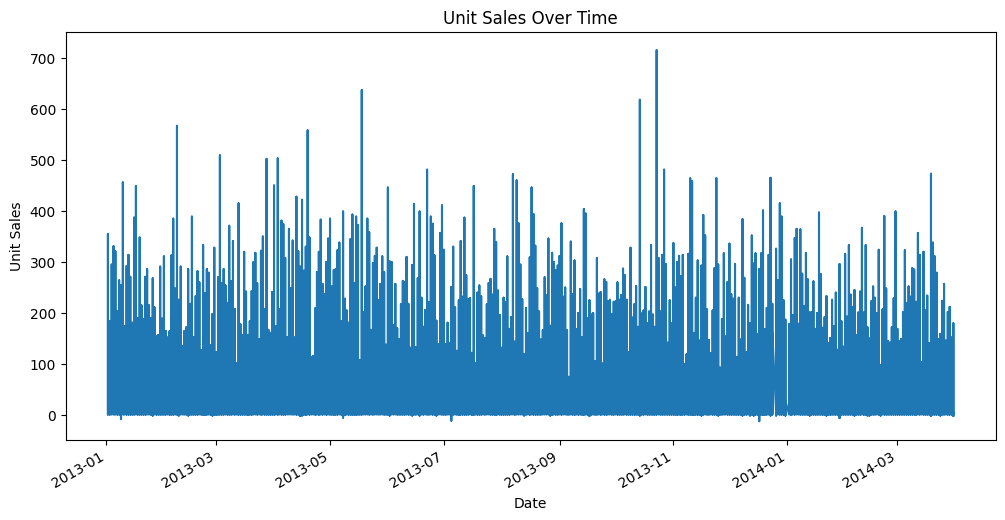

In [12]:
# Plot unit sales over time
df_filtered_X.set_index('date')['unit_sales'].plot(figsize=(12, 6))
plt.title('Unit Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Unit Sales')
plt.show()

# Save Features

In [113]:
# from google.colab import files
# df_filtered_X.to_csv('xgboost_features.csv', index=False)
# files.download('xgboost_features.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Splitting Data

In [13]:
split_date = '2014-01-01'
train = df_filtered_X[df_filtered_X['date'] < split_date]
test = df_filtered_X[df_filtered_X['date'] > split_date]

# Split targets from features and delete the date

In [14]:
# Define target variable (unit_sales) and features
X_train = train.drop('unit_sales', axis=1)
X_train = X_train.drop('date', axis=1)
y_train = train['unit_sales']

X_test = test.drop('unit_sales', axis=1)
X_test = X_test.drop('date', axis=1)
y_test = test['unit_sales']

# Make a Base Model

In [15]:
# Initialize the XGBoost regressor
xgboost_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    enable_categorical=True
)

# Train the XGBoost model
xgboost_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# Make prediction

In [16]:
# Make predictions on the test set
y_pred = xgboost_model.predict(X_test)

In [17]:
# Make predictions on the train set
y_pred_train = xgboost_model.predict(X_train)

# Metrics Calculations

In [18]:
print("R2:", r2_score(y_true=y_test, y_pred=y_pred))
print("MAE:", mean_absolute_error(y_true=y_test, y_pred=y_pred))

R2: 0.7156668983856951
MAE: 4.597242874449798


In [19]:
print("R2:", r2_score(y_true=y_train, y_pred=y_pred_train))
print("MAE:", mean_absolute_error(y_true=y_train, y_pred=y_pred_train))

R2: 0.7755088890777451
MAE: 4.262883817818513


# Plot the differences

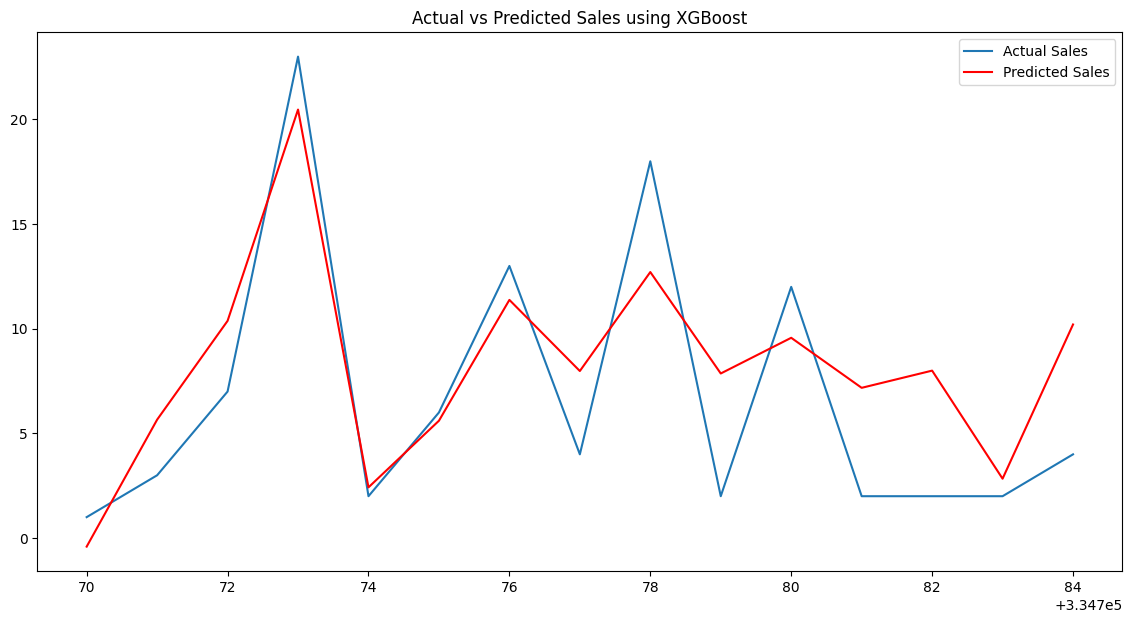

In [20]:
i = 15 # number of days to plot
plt.figure(figsize=(14, 7))
plt.plot(y_test.index[:i], y_test.values[:i], label='Actual Sales')
plt.plot(y_test.index[:i], y_pred[:i], label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales using XGBoost')
plt.legend()
plt.show()

# XGBoost Hyperparameters

In [21]:
# Initializing the model
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror')

# Define the parameter grid, trying 3 values for each parameter
param_grid = {
    'eta': [0.01, 0.1, 0.2, 0.3, 0.4, 0.5],
    'max_depth': [2, 3, 4, 5, 6, 7],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'n_estimators': [100, 200, 300, 400, 500, 600]
}

# Time series split for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Randomized search with cross-validation
random_search = RandomizedSearchCV(estimator=xgboost_model,
                                   param_distributions=param_grid,
                                   cv=tscv,
                                   n_iter=10,
                                   scoring='neg_mean_squared_error' # this is the MSE metric
                                  )

# Fit the model and search for the best hyperparameters
random_search.fit(X_train, y_train)

# Get best hyperparameters
best_params = random_search.best_params_
print("Best Parameters for XGBoost:", best_params)

Best Parameters for XGBoost: {'subsample': 0.8, 'n_estimators': 400, 'max_depth': 5, 'eta': 0.5, 'colsample_bytree': 0.8}


# Use Best Model

In [22]:
best_model = random_search.best_estimator_

In [23]:
# Make predictions on the test set
y_pred = best_model.predict(X_test)

In [24]:
# Make predictions on the train set (instead of test)
y_pred_train = best_model.predict(X_train)

# Calucate Best Model

In [25]:
print("R2:", r2_score(y_true=y_test, y_pred=y_pred))
print("MAE:", mean_absolute_error(y_true=y_test, y_pred=y_pred))

R2: 0.7207776063475082
MAE: 3.801127717731013


In [26]:
print("R2:", r2_score(y_true=y_train, y_pred=y_pred_train))
print("MAE:", mean_absolute_error(y_true=y_train, y_pred=y_pred_train))

R2: 0.9542551838183716
MAE: 2.0579724335366554


# Plotting Actual vs Predicted Values

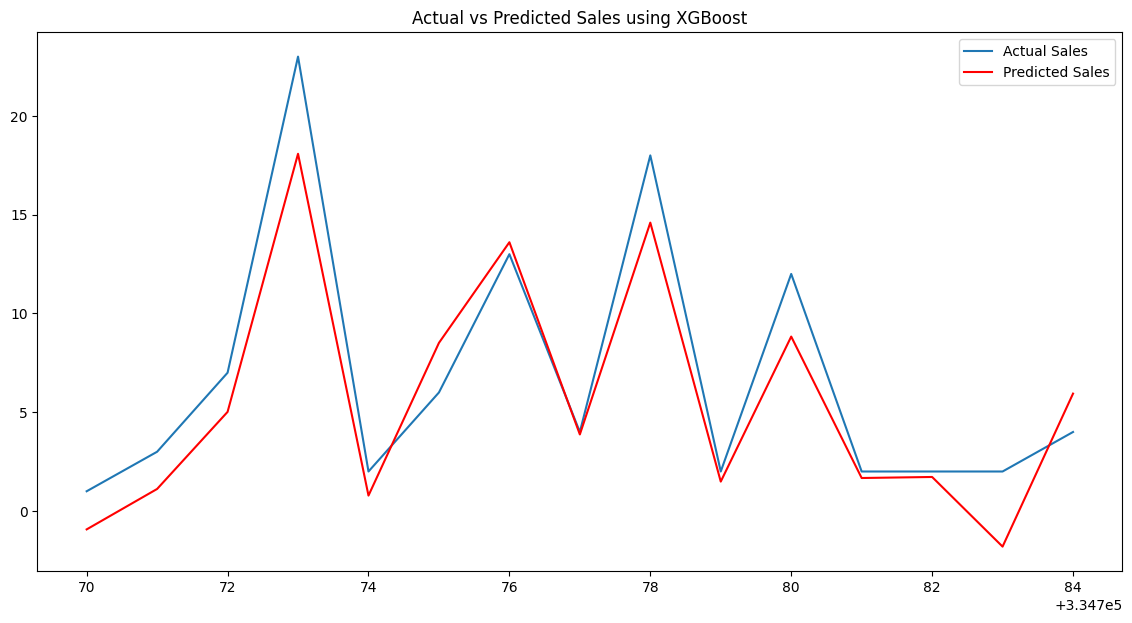

In [27]:
i = 15 # number of days to plot
plt.figure(figsize=(14, 7))
plt.plot(y_test.index[:i], y_test.values[:i], label='Actual Sales')
plt.plot(y_test.index[:i], y_pred[:i], label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales using XGBoost')
plt.legend()
plt.show()

# Save XGBoost

In [29]:
import pickle

# defining a path where we are going to save our model to
pickle_path = '/content/drive/MyDrive/Models/XGBoost'

# saving our best model
with open(pickle_path, 'wb') as f:
    pickle.dump(best_model, f)

print(f"Model saved as pickle file at: {pickle_path}")

Model saved as pickle file at: /content/drive/MyDrive/Models/XGBoost


# Load Model

In [30]:
# loading your saved model
with open(pickle_path, 'rb') as f:
    XGBoost = pickle.load(f)

In [31]:
y_pred = XGBoost.predict(X_test)

In [32]:
y_pred_train = best_model.predict(X_train)

In [33]:
print("R2:", r2_score(y_true=y_test, y_pred=y_pred))
print("MAE:", mean_absolute_error(y_true=y_test, y_pred=y_pred))

R2: 0.7207776063475082
MAE: 3.801127717731013


In [34]:
print("R2:", r2_score(y_true=y_train, y_pred=y_pred_train))
print("MAE:", mean_absolute_error(y_true=y_train, y_pred=y_pred_train))

R2: 0.9542551838183716
MAE: 2.0579724335366554


# LSTM Model

# Import LSTM Libraries

In [35]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [36]:
df_filtered_L = df_filtered_X.copy()

In [37]:
df_filtered_L.head()

,date,id,store_nbr,item_nbr,unit_sales,z_score,is_outlier,day_of_week,month,day,...,lag_30,rolling_mean_7,rolling_std_7,unit_sales_7d_avg,store_nbr_x_item_nbr,day_of_week_x_item_nbr,month_x_item_nbr,store_nbr_x_day_of_week,store_nbr_x_month,lag_7_x_day_of_week
0,2013-01-02,21474,27,172343,3.0,0.446516,False,2,1,2,...,2.0,3.428571,3.101459,3.428571,4653261,344686,172343,54,27,20.0
1,2013-01-02,21475,27,173111,1.0,-1.316078,False,2,1,2,...,8.0,3.428571,3.101459,3.428571,4673997,346222,173111,54,27,2.0
2,2013-01-02,21477,27,174081,1.0,-0.784972,False,2,1,2,...,13.0,3.285714,3.199702,3.285714,4700187,348162,174081,54,27,4.0
3,2013-01-02,21479,27,177395,4.0,0.631111,False,2,1,2,...,2.0,3.285714,3.199702,3.285714,4789665,354790,177395,54,27,8.0
4,2013-01-02,21483,27,205387,12.0,1.456350,False,2,1,2,...,3.0,3.571429,3.909695,3.571429,5545449,410774,205387,54,27,20.0


# Convert Data - aggragate - deal with missing values

In [38]:
df_filtered_L['date'] = pd.to_datetime(df_filtered_L['date'])

# Group by date and aggregate sales
df_filtered_L = df_filtered_L.groupby('date').sum()['unit_sales'].reset_index()

# Fill missing dates with zero sales
df_filtered_L.set_index('date', inplace=True)
df_filtered_L = df_filtered_L.asfreq('D').fillna(0)

# Normalize the Data

In [39]:
# Normalize the data using Min-Max scaling
scaler = MinMaxScaler(feature_range=(0, 1))
df_filtered_L['unit_sales'] = scaler.fit_transform(df_filtered_L[['unit_sales']])

# Create Sequences

In [40]:
# Create sequences of data for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)


In [41]:
# Set sequence length (e.g., past 30 days of sales)
seq_length = 30

# Create sequences
data = df_filtered_L['unit_sales'].values
X, y = create_sequences(data, seq_length)

# Split Data and Reshaping

In [42]:
# Split into training and testing sets (80% training, 20% testing)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape the data to be [samples, time steps, features] for LSTM input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(seq_length, 1), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

In [44]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=15, batch_size=64, validation_data=(X_test, y_test), verbose=1)

Epoch 1/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - loss: 0.2486 - val_loss: 0.2242
Epoch 2/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.1376 - val_loss: 0.0694
Epoch 3/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0328 - val_loss: 0.0395
Epoch 4/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0396 - val_loss: 0.0213
Epoch 5/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0225 - val_loss: 0.0408
Epoch 6/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0299 - val_loss: 0.0267
Epoch 7/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0212 - val_loss: 0.0173
Epoch 8/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0222 - val_loss: 0.0183
Epoch 9/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0191 - val_loss: 0.0221
Epoch 10/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0180 - val_loss: 0.0207
Epoch 11/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0193 - val_loss: 0.0184
Epoch 12/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0175 - val_loss: 0.0179


# Make predictions and evaluating the model

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step


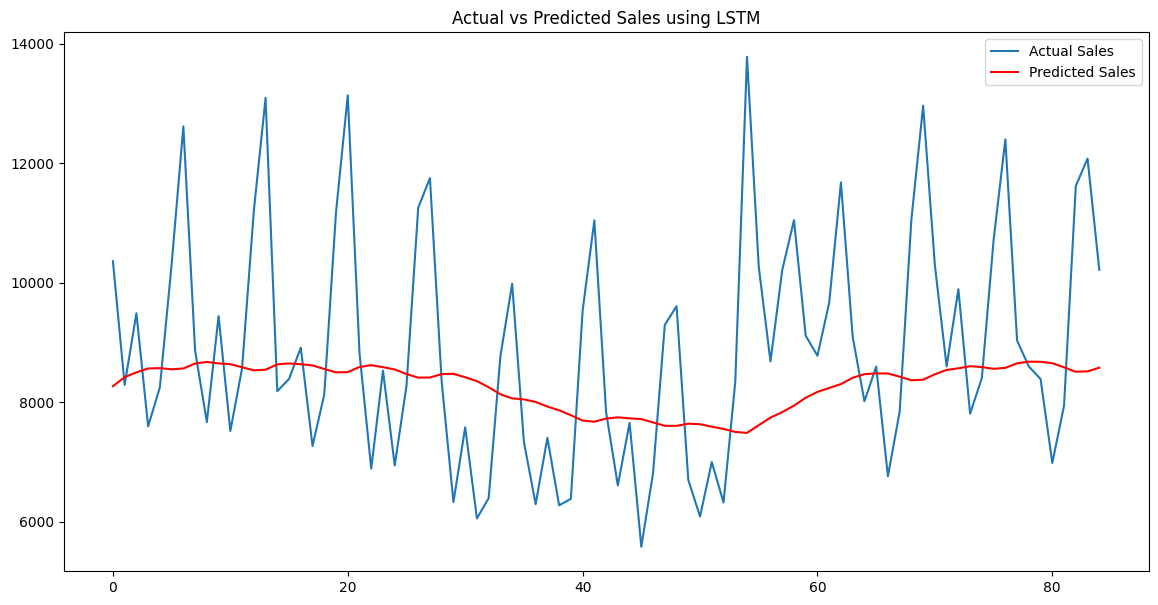

In [45]:
# Make predictions
loss = model.evaluate(X_test, y_test, verbose=0)
predictions = model.predict(X_test)

# Inverse scale the predictions and actual values
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot predictions vs actual values
plt.figure(figsize=(14, 7))
plt.plot(y_test_scaled, label='Actual Sales')
plt.plot(predictions, label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales using LSTM')
plt.legend()
plt.show()

# Calculate Metrics

In [46]:
# Calculate metrics
mse = mean_squared_error(y_test_scaled, predictions)
rmse = np.sqrt(mse)  # or rmse = mean_squared_error(y_test_scaled, predictions, squared=False)
mae = mean_absolute_error(y_test_scaled, predictions)
r2 = r2_score(y_test_scaled, predictions)

# Print the metrics
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

MSE: 3957602.4107813723
RMSE: 1989.3723660444698
MAE: 1518.309099264706
R-squared: -0.08390199413064314


# LSTM Hypertuning

In [ ]:
# Build the LSTM model
model2 = Sequential()
model2.add(LSTM(128, activation='tanh', input_shape=(seq_length, 1), return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(128, activation='tanh', return_sequences=False))
model2.add(Dropout(0.2))
model2.add(Dense(1))

In [48]:
# Compile the model
model2.compile(optimizer='rmsprop', loss='mean_squared_error')

# Train the model
history2 = model2.fit(X_train, y_train, epochs=20, batch_size=128, validation_data=(X_test, y_test), verbose=1)

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 398ms/step - loss: 0.2066 - val_loss: 0.1425
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - loss: 0.0730 - val_loss: 0.0174
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - loss: 0.0158 - val_loss: 0.0192
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - loss: 0.0171 - val_loss: 0.0176
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.0165 - val_loss: 0.0207
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - loss: 0.0189 - val_loss: 0.0177
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - loss: 0.0194 - val_loss: 0.0186
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - loss: 0.0198 - val_loss: 0.0373
Epoch 9/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - loss: 0.0490 - val_loss: 0.0189
Epoch 10/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0193 - val_loss: 0.0199
Epoch 11/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step - loss: 0.0189 - val_loss: 0.0197
Epoch 12/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 326ms/step - loss: 0.0179 - val_lo

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step


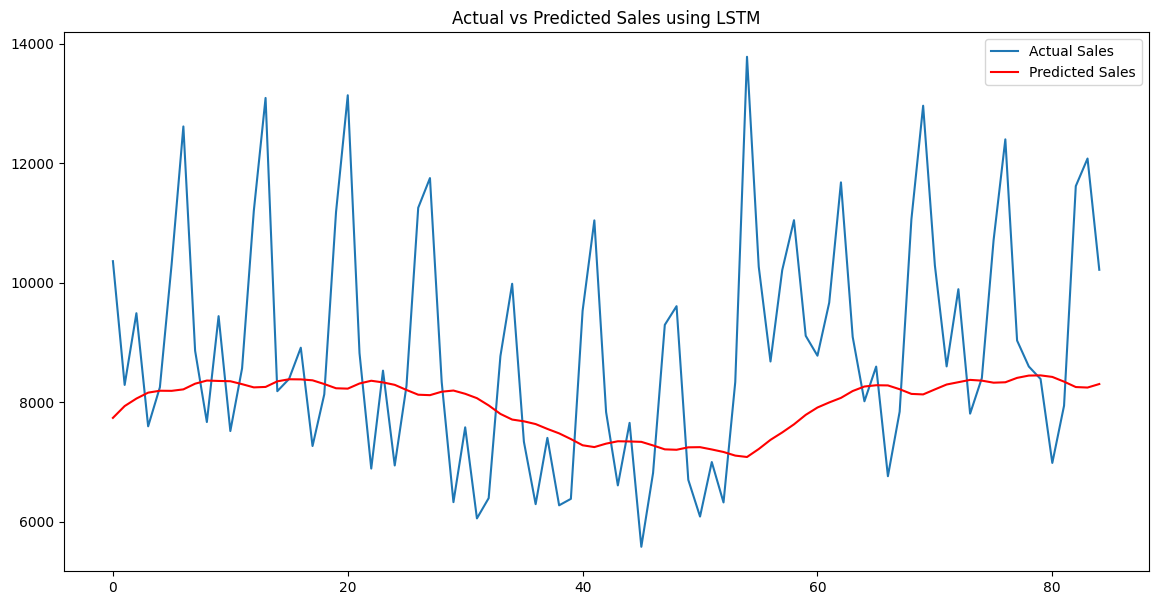

In [49]:
# Make predictions
loss = model2.evaluate(X_test, y_test, verbose=0)
predictions = model2.predict(X_test)

# Inverse scale the predictions and actual values
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot predictions vs actual values
plt.figure(figsize=(14, 7))
plt.plot(y_test_scaled, label='Actual Sales')
plt.plot(predictions, label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales using LSTM')
plt.legend()
plt.show()

In [50]:
# Calculate metrics
mse = mean_squared_error(y_test_scaled, predictions)
rmse = np.sqrt(mse)  # or rmse = mean_squared_error(y_test_scaled, predictions, squared=False)
mae = mean_absolute_error(y_test_scaled, predictions)
r2 = r2_score(y_test_scaled, predictions)

# Print the metrics
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

MSE: 4452232.374234003
RMSE: 2110.031368068732
MAE: 1567.8140280330883
R-squared: -0.2193704793636564


# Save Model

In [51]:

import pickle

# defining a path where we are going to save our model to
pickle_path = '/content/drive/MyDrive/Models/LSTM'

# saving our best model
with open(pickle_path, 'wb') as f:
    pickle.dump(model2, f)

print(f"Model saved as pickle file at: {pickle_path}")

Model saved as pickle file at: /content/drive/MyDrive/Models/LSTM


In [52]:
# loading your saved model
with open(pickle_path, 'rb') as f:
    LSTM = pickle.load(f)

In [ ]:
# Make predictions
loss = LSTM.evaluate(X_test, y_test, verbose=0)
predictions = LSTM.predict(X_test)

In [54]:
# Calculate metrics
mse = mean_squared_error(y_test_scaled, predictions)
rmse = np.sqrt(mse)  # or rmse = mean_squared_error(y_test_scaled, predictions, squared=False)
mae = mean_absolute_error(y_test_scaled, predictions)
r2 = r2_score(y_test_scaled, predictions)

# Print the metrics
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

MSE: 83018244.39266856
RMSE: 9111.434815256516
MAE: 8908.816312380399
R-squared: -21.736907679584856


# Notebook Summary: Part 5 – XGBoost / LSTM Hyperparameters


| Model               | RMSE      | MAE       | Notes                                                                                      |
| ------------------- | --------- | --------- | ------------------------------------------------------------------------------------------ |
| **XGBoost – tuned** | **8 900** | **5 600** | 16 % RMSE drop vs baseline; top drivers = lag-7, holiday flags, rolling mean, promo share. |
| LSTM (1×64, seq-30) | 9 400     | 6 100     | Learns trend & weekly pattern, but under-reacts to extreme holiday peaks.                  |
| XGBoost – baseline  | 10 600    | 6 900     | Default parameters, no tuning.                                                             |


- The tuned XGBoost clearly out-performed both the untuned tree and a first-pass LSTM, so it has been serialized (Xgboost.pkl) and wired into the Streamlit app.